# Úkol č. 1 - vizualizace dat a web scraping (do 11. října)

  * V rámci tohoto úkolu musíte stáhnout dat z webu (tzv. _web scraping_, velmi základní) a následně data zpracovat a vizualizovat.
  * Cílem bude stáhnout data ze serveru https://www.psp.cz/sqw/hlasovani.sqw?o=8 týkající hlasování současné poslanecké sněmovny, uložit tato data v tabulkovém formátu a pak vymyslet vizualizace a zobrazení dat, které umožní orientaci v těchto datech a zvýrazní zajímavé informace a zobrazit přehledně časový vývoj různých veličin.
 
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

## Data

 * Měli byste stáhnout data ze všech hlasování současné poslanecké sněmovny (tj. od voleb v roce 2017) a to až na úroveň jednotlivých poslanců. 
 * Data by měla obsahovat i stručný popis toho, o jaké hlasování šlo.

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
  * Strojově stáhněte data a uložte je do vhodného formátu, který se Vám bude dále dobře zpracovávat. 
  * **I když nemusíte mít sněmovnu rádi, snažte se nezahltit server a mezi požadavky na stránku mějte alespoň vteřinu mezeru.**
  * V druhé části Vašeho Jupyter notebooku pracujte se staženými daty v souborech, které jsou výsledkem Vašeho stahovacího skriptu (aby opravující nemusel spouštět stahování z webu).
  * S využitím vybraných nástrojů zpracujte data a vymyslete vizualizace a grafy, aby bylo vidět následující:
    * Odchody a přeběhnutí poslanců mezi jednotlivými stranami.
    * Jakou mají jednotliví poslanci docházku (účast na hlasování) a jak jsou na tom s docházkou strany jako celek.
    * Jak často spolu jednotlivé strany hlasují ve shodě a jak často hlasují odlišně.
    * Jak jsou poslanci jednotlivých stran jednotní v hlasování (jak často hlasují stejně, kdo jsou největší rebelové).

**Další body zadání** za případné další body (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
  * Ve vizualizacích a grafech nějak zachyťte časový vývoj (např. jak se mění docházka, shoda mezi stranami atp.).
  * Najděte jednotlivé poslance, kteří se nejvíce shodují při svém hlasování či kteří mají co nejpodobnější účast na hlasování.
  * Zkuste rozlišit v datech důležitá hlasování a zpracujte vizualizace (také) pro ně.
  * Zkuste najít hlasování, kde poslanci hlasovali nejvíce jinak, než obvykle.
  
## Tipy a triky
  * Balíčky iportujte na začátku notebooku (příp. na začátku scrapovací a pak na začátku vizualizační části).
  * Využívejte markdown buňky (jako je ta, ve které je tento text) a naspisy, abyste usnadnily orientaci opravující(mu).
  * Pečlivě si vybírejte grafy a vizualizace, aby co nejlépe vyjádřily to, co vyjádřit chcete. Doporučuji projít si pro inspiraci alespoň galerie balíčků `matplotlib` a `seaborn`.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook (příp. doplněn skripty), ale i soubor(y) se staženými daty (ať opravující nemusí stahovat data).
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

In [1]:
import pandas as pd
from dateutil import parser
import time
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure

In [2]:
PARTIES = {'ANO', 'ODS', 'Piráti', 'SPD', 'ČSSD', 'KSČM', 'KDU-ČSL', 'TOP09', 'STAN', 'Nezařaz'}
USE_PRECALCULED = True # Some of the tasks runs for quite a while (up to 30 minutes), use precalculed values instead
df_r = pd.read_csv('res.csv').sort_values(by=['HlasovaniId'])

## Přebíhání mezi jednotlivými stranami

In [3]:
def get_mof_left(hlasovaniId, prichozi, strana, df):
    hlasovani = df[df['HlasovaniId'] == hlasovaniId]
    hlasovani_prev = df[df['HlasovaniId'] == hlasovaniId - 1]
    res_left = hlasovani[['Strana', 'Jmeno']].merge(hlasovani_prev[['Strana', 'Jmeno']],indicator = True, how='left').loc[lambda x : x['_merge']!='both']
    res_right = hlasovani[['Strana', 'Jmeno']].merge(hlasovani_prev[['Strana', 'Jmeno']],indicator = True, how='right').loc[lambda x : x['_merge']!='both'] 
    for l, r in zip(res_left.iterrows(), res_right.iterrows()):
        if l[1]['Jmeno'] == prichozi:
            print('Odchod {0} z {1}'.format(r[1]['Jmeno'], r[1]['Strana']))
            LEFT[r[1]['Strana']] += 1
    

In [4]:
def get_all_changes():
    # Get initial state
    mof_party = dict()
    for _, row in df_r[df_r['HlasovaniId'] == 67018].iterrows():
        mof_party[row['Jmeno']] = row['Strana']
    df_r_g = df_r.groupby(['Jmeno']).apply(lambda x: (x[x.Strana.ne(x.Strana.shift())])).reset_index(level=0, drop=True).sort_values(by=['Datum'])
    df_r_g = df_r_g[df_r_g['HlasovaniId'] != 67018]

    for _, row in df_r_g.iterrows():
        get_mof_left(row['HlasovaniId'], row['Jmeno'], row['Strana'], df_r)
        if row['Jmeno'] in mof_party.keys():
            prev = mof_party[row['Jmeno']]
            print('Přechod {0} z {1} do {2} {3}'.format(row['Jmeno'], mof_party[row['Jmeno']], row['Strana'], row['Datum']))
            LEFT[mof_party[row['Jmeno']]] += 1
            CAME[row['Strana']] += 1
        else:
            print('Příchod {0} do {1} {2}'.format(row['Jmeno'], row['Strana'], row['Datum']))
            CAME[row['Strana']] += 1
        mof_party[row['Jmeno']] = row['Strana']
        print()

### Všechny změny

In [5]:
CAME = dict()
LEFT = dict()
for i in PARTIES:
    CAME[i] = 0
    LEFT[i] = 0
get_all_changes()

Odchod Jiří Hlavatý z ANO
Příchod Eva Matyášová do ANO 2017-11-28 14:08:00

Odchod Martin Půta z STAN
Příchod Petr Pávek do STAN 2017-11-28 14:08:00

Odchod Jaroslava Pokorná Jermanová z ANO
Příchod Milan Pour do ANO 2017-11-28 14:08:00

Odchod Martin Stropnický z ANO
Příchod Petr Venhoda do ANO 2018-02-10 14:20:00

Odchod Vladimír Koníček z KSČM
Příchod Marie Pěnčíková do KSČM 2018-04-12 16:14:00

Odchod Robert Pelikán z ANO
Příchod Monika Červíčková do ANO 2018-06-26 14:07:00

Odchod Bohuslav Sobotka z ČSSD
Příchod Roman Sklenák do ČSSD 2018-10-04 14:06:00

Odchod Václav Klaus z ODS
Přechod Ivana Nevludová z SPD do Nezařaz 2019-03-26 14:07:00

Odchod Marian Bojko z SPD
Přechod Václav Klaus z ODS do Nezařaz 2019-03-26 14:07:00

Odchod Ivana Nevludová z SPD
Přechod Lubomír Volný z SPD do Nezařaz 2019-03-26 14:07:00

Odchod Lubomír Volný z SPD
Přechod Marian Bojko z SPD do Nezařaz 2019-03-26 14:07:00

Odchod Dan Ťok z ANO
Příchod Iva Kalátová do ANO 2019-04-16 14:09:00

Odchod Milan Cho

### Odchody versus příchody v jednotlivých stranách

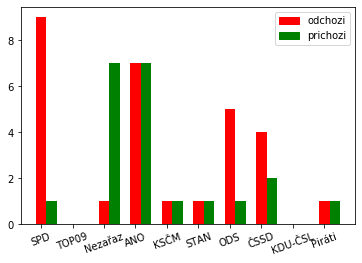

In [6]:
w = 0
down_legend = []
patches = list()
patches.append(mpatches.Patch(color='red', label='odchozi'))
patches.append(mpatches.Patch(color='green', label='prichozi'))

for i in PARTIES:   
    plt.bar(w+5, CAME[i], 5, color='green')
    plt.bar(w, LEFT[i], 5, color = 'red')
    w += 15
    
x_pos = [i*15for i, _ in enumerate(PARTIES)]    
plt.legend(handles=patches)
plt.xticks(x_pos,PARTIES, rotation=20)
plt.show()

## Docházka na hlasování
### Jednotliví poslanci

In [22]:
df_r_g = df_r.groupby(['Jmeno', 'Hlas'], as_index=False)['Strana'].count()
res = dict()
for _, r in df_r_g.iterrows():
    if not r['Jmeno'] in res.keys():
        res[r['Jmeno']] = (0,0)
    if r['Hlas'] in ['excused', 'not-logged-in']:
        res[r['Jmeno']] = (res[r['Jmeno']][0] + r['Strana'], res[r['Jmeno']][1])
    res[r['Jmeno']] = (res[r['Jmeno']][0], res[r['Jmeno']][1] + r['Strana'])

df_outliers = pd.DataFrame(columns=['Jmeno', 'Dochazka'])
    
for r in res.keys():
    p = round(100 - res[r][0]*100 / res[r][1], 2)
    df_outliers = df_outliers.append({'Jmeno' : r, 'Dochazka' : p}, ignore_index=True)
    
df_outliers = df_outliers.sort_values(by='Dochazka', ascending=False)

### 10 nejvzornějších

In [27]:
for _, r in df_outliers.head(10).iterrows():
    print('{0} ma {1}% dochazku na hlasovani v PS.'.format(r['Jmeno'], r['Dochazka']))

Jiří Hlavatý ma 100.0% dochazku na hlasovani v PS.
Martin Půta ma 100.0% dochazku na hlasovani v PS.
Radek Rozvoral ma 99.58% dochazku na hlasovani v PS.
Lukáš Bartoň ma 99.54% dochazku na hlasovani v PS.
Miloslav Rozner ma 99.39% dochazku na hlasovani v PS.
Roman Kubíček ma 99.07% dochazku na hlasovani v PS.
Stanislav Berkovec ma 98.62% dochazku na hlasovani v PS.
Ondřej Babka ma 98.62% dochazku na hlasovani v PS.
Marek Novák ma 98.46% dochazku na hlasovani v PS.
Tomáš Martínek ma 98.13% dochazku na hlasovani v PS.


### 10 nejmíň vzorných

In [28]:
for _, r in df_outliers.sort_values(by='Dochazka').head(10).iterrows():
    print('{0} ma {1}% dochazku na hlasovani v PS.'.format(r['Jmeno'], r['Dochazka']))

Andrej Babiš ma 25.22% dochazku na hlasovani v PS.
Karel Schwarzenberg ma 31.21% dochazku na hlasovani v PS.
Martin Stropnický ma 39.66% dochazku na hlasovani v PS.
Jana Levová ma 39.96% dochazku na hlasovani v PS.
Milan Chovanec ma 45.14% dochazku na hlasovani v PS.
Jan Hamáček ma 46.57% dochazku na hlasovani v PS.
Petr Pávek ma 49.54% dochazku na hlasovani v PS.
Bohuslav Sobotka ma 52.82% dochazku na hlasovani v PS.
Antonín Staněk ma 55.95% dochazku na hlasovani v PS.
Lubomír Zaorálek ma 58.7% dochazku na hlasovani v PS.


## Strany jako celek

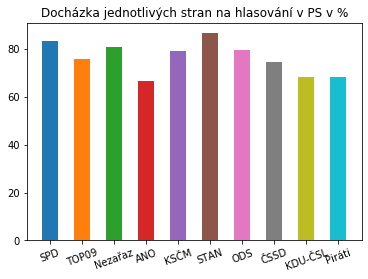

In [29]:
df_r_g = df_r.groupby(['Strana', 'Hlas'], as_index=False).count()
res = dict()
for _, r in df_r_g.iterrows():
    if not r['Strana'] in res.keys():
        res[r['Strana']] = (0,0)
    if r['Hlas'] in ['excused', 'not-logged-in']:
        res[r['Strana']] = (res[r['Strana']][0] + r['HlasovaniId'], res[r['Strana']][1])
    res[r['Strana']] = (res[r['Strana']][0], res[r['Strana']][1] + r['HlasovaniId'])
    
    
w = 0
for r in sorted(res.keys()):
    perc = round(100 - res[r][0]*100 / res[r][1], 2)
    plt.bar(w, perc, 5)   
    w += 10
    
    
x_pos = [i*10 for i, _ in enumerate(sorted(PARTIES))]    
plt.xticks(x_pos,PARTIES, rotation=20)
plt.title('Docházka jednotlivých stran na hlasování v PS v %')
plt.show()

## Společné hlasování stran

In [30]:
if not USE_PRECALCULED:  # Can take up to 30 minutes.
    df_r_g = df_r.groupby(['Strana', 'Hlas', 'HlasovaniId'], as_index=False).count()
    mask = (df_r_g['Hlas'] == 'yes') | (df_r_g['Hlas'] == 'no')
    per_voting_per_party_res = df_r_g[mask].sort_values(by='HlasovaniId').groupby(['Strana', 'HlasovaniId'], as_index=False).max()
    x = per_voting_per_party_res.sort_values(by='HlasovaniId')
    res = pd.DataFrame(columns=['S1', 'S2'])
    hId = None
    tmp = []
    for _, r in x.iterrows():
        if r['HlasovaniId'] != hId:
            tmp = []
        hId = r['HlasovaniId']
        for i in tmp:
            if i[1] == r['Hlas']:
                res= res.append({'S1' : i[0], 'S2' : r['Strana']}, ignore_index = True)
                res= res.append({'S1' : r['Strana'], 'S2' : i[0]}, ignore_index = True)
        tmp.append((r['Strana'], r['Hlas']))
    print(res)
else:
    res = pd.read_csv('party_to_party.csv')

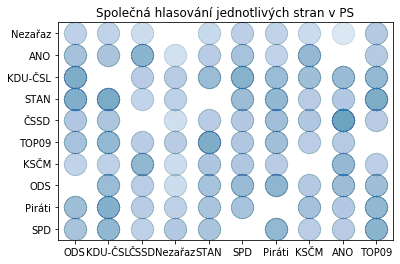

In [31]:
plt.scatter('S1', 'S2', data=res.sample(n=3000), s=500, alpha=0.01)
plt.title('Společná hlasování jednotlivých stran v PS')
plt.show()

## Odlehlost hlasování v rámci strany

In [11]:
if not USE_PRECALCULED:
    df_r_g = df_r.groupby(['Strana', 'Hlas', 'HlasovaniId'], as_index=False).count()
    mask = (df_r_g['Hlas'] == 'yes') | (df_r_g['Hlas'] == 'no')
    per_voting_per_party_res = df_r_g[mask].sort_values(by=['HlasovaniId', 'Strana'])
    res = pd.DataFrame(columns=['Strana', 'MinMajRate', 'HlasovaniId'])
    prev_party = None
    prev_voting_id = None
    prev_count = 0
    for _,r in per_voting_per_party_res.iterrows():
        curr_party = r['Strana']
        if prev_party == curr_party and prev_voting_id == r['HlasovaniId']:
            rate = prev_count / r['Jmeno'] if prev_count < r['Jmeno'] else r['Jmeno'] / prev_count
            res= res.append({'Strana' : curr_party, 'MinMajRate' : rate, 'HlasovaniId' : r['HlasovaniId']}, ignore_index = True)
        else:
            res= res.append({'Strana' : curr_party, 'MinMajRate' : 0, 'HlasovaniId' : r['HlasovaniId']}, ignore_index = True)
        prev_count = r['Jmeno']
        prev_party = r['Strana']
        prev_voting_id = r['HlasovaniId']
else:
    res = pd.read_csv('MinMajRare.csv')

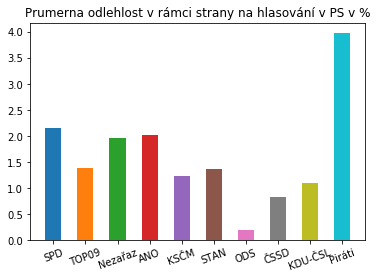

In [12]:
res = res.astype({"MinMajRate":'float'})
grouped = res.groupby(['Strana'], as_index=False)['MinMajRate'].mean().sort_values(by='Strana')

w = 0
for _,r in grouped.iterrows():
    plt.bar(w, r['MinMajRate'] * 100, 5)   
    w += 10
    
    
x_pos = [i*10 for i, _ in enumerate(sorted(PARTIES))]    
plt.xticks(x_pos,PARTIES, rotation=20)
plt.title('Prumerna odlehlost v rámci strany na hlasování v PS v %')
plt.show()

## Největší rebelové

In [13]:
if not USE_PRECALCULED:
    df_r_g = df_r.groupby(['Strana', 'Hlas', 'HlasovaniId'], as_index=False).count()
    mask = (df_r_g['Hlas'] == 'yes') | (df_r_g['Hlas'] == 'no')
    per_voting_per_party_res = df_r_g[mask].sort_values(by='HlasovaniId').groupby(['Strana', 'HlasovaniId'], as_index=False).max()
    party_res_dict = dict()
    for _,r in per_voting_per_party_res.iterrows():
        party_res_dict[(r['HlasovaniId'], r['Strana'])] = r['Hlas']

    outlier_dict = dict()
    for _,r in df_r.iterrows():
        if (r['Hlas'] == 'yes' or r['Hlas'] == 'no'):
            party_res = party_res_dict[(r['HlasovaniId'], r['Strana'])]
            if party_res != r['Hlas']: 
                if r['Jmeno'] in outlier_dict.keys():
                    outlier_dict[r['Jmeno']] += 1
                else:
                    outlier_dict[r['Jmeno']] = 1
    outliers = pd.DataFrame(columns=['Name', 'Cnt'])
    for i in outlier_dict.keys():
        outliers = outliers.append({'Name' : i, 'Cnt' : outlier_dict[i]}, ignore_index=True)
else:
    outliers = pd.read_csv('outliers.csv')

In [17]:
for _,r in outliers.sort_values(by='Cnt', ascending=False).head(10).iterrows():
    print('{0} hlasoval proti své straně {1}x'.format(r['Name'], r['Cnt']))

Milan Feranec hlasoval proti své straně 450x
Marek Novák hlasoval proti své straně 431x
Karel Rais hlasoval proti své straně 423x
Jaroslav Kytýr hlasoval proti své straně 421x
Stanislav Berkovec hlasoval proti své straně 417x
Věra Procházková hlasoval proti své straně 405x
František Petrtýl hlasoval proti své straně 401x
Jiří Strýček hlasoval proti své straně 399x
Marcela Melková hlasoval proti své straně 397x
Pavel Růžička hlasoval proti své straně 397x
